<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [22]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
import plotly.express as px
from scipy.stats import chi2_contingency
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import pickle
from sklearn.preprocessing import PolynomialFeatures

In [23]:
data = pd.read_csv('data_clean_v1.csv')

In [24]:
data.head()

,Unnamed: 0,age,gender,country,education,role,experience_prog,programming_lang_c,experience_ml,industry,company_size,team_size,salary,country_group,company_size_g,team_size_g,salary_avg,salary_group,role_group
0,1,50-54,Man,India,Bachelor’s degree,Other,5-10 years,2,5-10 years,Manufacturing/Fabrication,50-249 employees,3-4,25000-29999,India,Medium,Small,27500.0,between 10k and 30k,Other
1,2,50-54,Man,Indonesia,Master’s degree,Program/Project Manager,20+ years,4,Under 1 year,Manufacturing/Fabrication,"1000-9,999 employees",1-2,60000-69999,Other,Large,Small,65000.0,between 50k and 80k,Data Analyst
2,3,22-24,Man,Pakistan,Master’s degree,Software Engineer,1-3 years,3,No experience,Academics/Education,"1000-9,999 employees",0,0-999,Other,Large,No team,500.0,less than 10k,Data Engineer
3,4,45-49,Man,Mexico,Doctoral degree,Research Scientist,20+ years,1,5-10 years,Academics/Education,"1000-9,999 employees",0,30000-39999,Other,Large,No team,35000.0,between 30k and 50k,Data Scientist
4,5,45-49,Man,India,Doctoral degree,Other,< 1 years,3,10-20 years,Academics/Education,50-249 employees,5-9,30000-39999,India,Medium,Small,35000.0,between 30k and 50k,Other


In [25]:
data = data.drop(['Unnamed: 0'], axis=1)

In [57]:
data_all = data[data['country_group'] != 'Other']

In [58]:
data_all.shape

(7727, 18)

In [59]:
def boxcox_transform(data, skip_columns=[]):
    numeric_cols = data.select_dtypes(np.number).columns
    _ci = {column: None for column in numeric_cols}
    for column in numeric_cols:
        if column not in skip_columns:
# since i know any columns should take negative numbers, to avoid -inf in df
            data[column] = np.where(data[column]<=0, np.NAN, data[column]) 
            data[column] = data[column].fillna(data[column].mean())
            transformed_data, ci = stats.boxcox(data[column])
            data[column] = transformed_data
            _ci[column] = [ci] 
    return data, _ci

In [28]:
data_eu, _ci = boxcox_transform(data_eu, skip_columns = ['programming_lang_c'])
data_eu

,age,gender,country,education,role,experience_prog,programming_lang_c,experience_ml,industry,company_size,team_size,salary,country_group,company_size_g,team_size_g,salary_avg,salary_group,role_group
10,35-39,Man,Greece,Doctoral degree,Research Scientist,10-20 years,4,4-5 years,Academics/Education,50-249 employees,5-9,10000-14999,Europe,Medium,Small,59.037439,between 10k and 30k,Data Scientist
11,50-54,Man,Belgium,Bachelor’s degree,Data Analyst,20+ years,2,1-2 years,Energy/Mining,"1000-9,999 employees",5-9,2000-2999,Europe,Large,Small,34.263258,less than 10k,Data Analyst
17,25-29,Woman,Poland,Master’s degree,Machine Learning Engineer,3-5 years,2,Under 1 year,Computers/Technology,0-49 employees,3-4,25000-29999,Europe,Small,Small,76.612364,between 10k and 30k,Data Engineer
24,25-29,Man,Italy,Master’s degree,Other,1-3 years,2,Under 1 year,Energy/Mining,0-49 employees,1-2,30000-39999,Europe,Small,Small,82.921494,between 30k and 50k,Other
35,35-39,Woman,Russia,I prefer not to answer,Data Scientist,1-3 years,2,No experience,Academics/Education,"1000-9,999 employees",3-4,0-999,Europe,Large,Small,19.355640,less than 10k,Data Scientist
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14345,30-34,Man,Portugal,Master’s degree,Data Engineer,10-20 years,4,5-10 years,Manufacturing/Fabrication,"1000-9,999 employees",20+,70000-79999,Europe,Large,Large,106.331076,between 50k and 80k,Data Engineer
14348,25-29,Man,Germany,Master’s degree,Data Scientist,1-3 years,2,1-2 years,Computers/Technology,"10,000 or more employees",20+,60000-69999,Europe,Large,Large,101.495874,between 50k and 80k,Data Scientist
14358,40-44,Man,Russia,I prefer not to answer,Data Engineer,< 1 years,2,Under 1 year,Computers/Technology,"10,000 or more employees",20+,0-999,Europe,Large,Large,19.355640,less than 10k,Data Engineer
14365,35-39,Man,Russia,Bachelor’s degree,Software Engineer,3-5 years,4,No experience,Insurance/Risk Assessment,250-999 employees,10-14,20000-24999,Europe,Large,Medium,71.716456,between 10k and 30k,Data Engineer


In [60]:
data_all, _ci = boxcox_transform(data_all, skip_columns = ['programming_lang_c'])
data_all

,age,gender,country,education,role,experience_prog,programming_lang_c,experience_ml,industry,company_size,team_size,salary,country_group,company_size_g,team_size_g,salary_avg,salary_group,role_group
0,50-54,Man,India,Bachelor’s degree,Other,5-10 years,2,5-10 years,Manufacturing/Fabrication,50-249 employees,3-4,25000-29999,India,Medium,Small,24.915032,between 10k and 30k,Other
4,45-49,Man,India,Doctoral degree,Other,< 1 years,3,10-20 years,Academics/Education,50-249 employees,5-9,30000-39999,India,Medium,Small,26.106034,between 30k and 50k,Other
5,30-34,Man,India,Bachelor’s degree,Data Scientist,5-10 years,1,2-3 years,Computers/Technology,"10,000 or more employees",3-4,15000-19999,India,Large,Small,22.798869,between 10k and 30k,Data Scientist
10,35-39,Man,Greece,Doctoral degree,Research Scientist,10-20 years,4,4-5 years,Academics/Education,50-249 employees,5-9,10000-14999,Europe,Medium,Small,21.316701,between 10k and 30k,Data Scientist
11,50-54,Man,Belgium,Bachelor’s degree,Data Analyst,20+ years,2,1-2 years,Energy/Mining,"1000-9,999 employees",5-9,2000-2999,Europe,Large,Small,15.201037,less than 10k,Data Analyst
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14367,18-21,Man,India,Bachelor’s degree,Data Analyst,1-3 years,2,Under 1 year,Academics/Education,0-49 employees,0,0-999,India,Small,No team,10.431093,less than 10k,Data Analyst
14369,35-39,Man,Italy,Bachelor’s degree,Program/Project Manager,3-5 years,2,1-2 years,Computers/Technology,"1000-9,999 employees",1-2,60000-69999,Europe,Large,Small,29.374205,between 50k and 80k,Data Analyst
14370,18-21,Man,India,Bachelor’s degree,Software Engineer,1-3 years,4,Under 1 year,Academics/Education,0-49 employees,1-2,0-999,India,Small,Small,10.431093,less than 10k,Data Engineer
14371,60-69,Man,USA,Bachelor’s degree,Program/Project Manager,20+ years,2,Under 1 year,Academics/Education,"10,000 or more employees",5-9,300000-499999,USA,Large,Small,40.986080,more than 125k,Data Analyst


In [61]:
def remove_outliers(data, threshold=1.5, in_columns=data.select_dtypes(np.number).columns, skip_columns=[]):
    for column in in_columns:
        if column not in skip_columns:
            upper = np.percentile(data[column],75)
            lower = np.percentile(data[column],25)
            iqr = upper - lower
            upper_limit = upper + (threshold * iqr)
            lower_limit = lower - (threshold * iqr)
            data = data[(data[column]>lower_limit) & (data[column]<upper_limit)]
    return data

In [30]:
data_eu = remove_outliers(data_eu, threshold=1.5)

In [62]:
data_all = remove_outliers(data_all, threshold=1.5)

In [63]:
def dist_boxplot_num(data, skip_columns=[]):
    for col in data.select_dtypes(np.number):
        if col not in skip_columns:
            fig, axes = plt.subplots(1, 2, figsize=(15, 5))
            sns.distplot(data[col], ax=axes[0])
            sns.boxplot(data[col], ax=axes[1])
            plt.show()

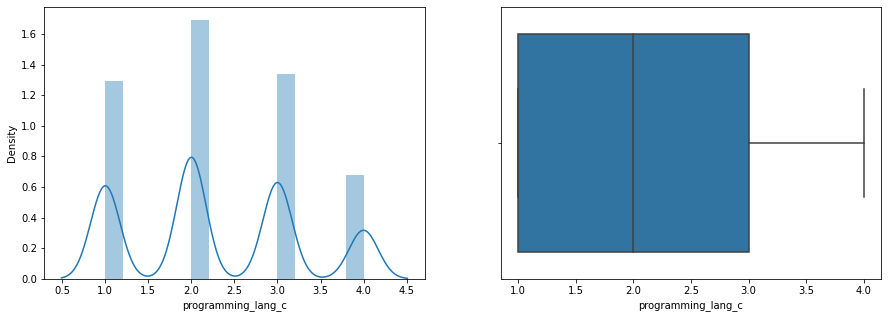

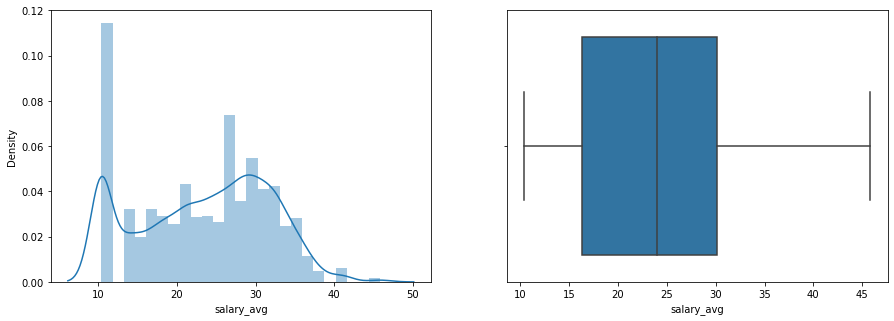

In [64]:
dist_boxplot_num(data_all)

In [33]:
data_eu = data_eu.drop(['country_group','company_size', 'salary', 'team_size', 'salary_group','role'], axis=1)

In [65]:
data_all = data_all.drop(['country_group','company_size', 'salary', 'team_size', 'salary_group','role'], axis=1)

In [34]:
data_eu = data_eu[(data_eu.education != 'I prefer not to answer')]

In [35]:
data_eu = data_eu[(data_eu.experience_ml != 'No experience')]

In [36]:
data_eu = data_eu[(data_eu.age != '70')]

In [37]:
X = data_eu.drop('salary_avg', axis=1)
y = data_eu['salary_avg']

In [66]:
X = data_all.drop('salary_avg', axis=1)
y = data_all['salary_avg']

In [38]:
ordinal_cols_mapping = [{
    "col": "age",
    "mapping": {
        '18-21': 0,
        '22-24': 1,
        '25-29': 2,
        '30-34': 3,
        '35-39': 4,
        '40-44': 5,
        '45-49': 6,
        '50-54': 7,
        '55-59': 8,
        '60-69': 9    
    }}, {
    "col": "gender",
    "mapping": {
        'Man': 0,
        'Woman': 1,
        'Other': 2
    }}, {        
    "col": "education",
    "mapping": {
        'High school': 0,
        'Some college': 1,
        'Bachelor’s degree': 2,
        'Master’s degree': 3,
        'Doctoral degree': 4,
        'Professional doctorate': 5
    }}, {
    "col": "experience_prog",
    "mapping": {
        '< 1 years':0, 
        '1-3 years':1,
        '3-5 years':2,
        '5-10 years':3,
        '10-20 years':4,
        '20+ years':5 
    }}, {
    "col": "experience_ml",
    "mapping": {
        'Under 1 year':0, 
        '1-2 years':1,
        '2-3 years':2,
        '3-4 years':3,
        '4-5 years':4,
        '5-10 years':5,
        '10-20 years':6,
        '20 or more years':7
    }}, {
    "col": "company_size_g",
    "mapping": {
        'Small':0, 
        'Medium':1,
        'Large':2
    }}, {
    "col": "industry",
    "mapping": {
        'Computers/Technology': 0,
        'Academics/Education': 1,
        'Accounting/Finance': 2,
        'Other': 3,
        'Medical/Pharmaceutical': 4,
        'Manufacturing/Fabrication': 5,
        'Government/Public Service': 6,
        'Online Service/Internet-based Services': 7,
        'Energy/Mining': 8,
        'Retail/Sales': 9,
        'Insurance/Risk Assessment': 10,
        'Broadcasting/Communications': 11,
        'Shipping/Transportation': 12,
        'Marketing/CRM': 13,
        'Online Business/Internet-based Sales': 14,
        'Military/Security/Defense': 15,
        'Non-profit/Service': 16,
        'Hospitality/Entertainment/Sports': 17
       
    }}, {
    "col": "country",
    "mapping": {
        'Russia': 0,
        'UK': 1,
        'Spain': 2,
        'Germany': 3,
        'France': 4,
        'Italy': 5,
        'Poland': 6,
        'Netherlands': 7,
        'Ukraine': 8,
        'Portugal': 9,
        'Greece': 10,
        'Ireland': 11,
        'Sweden': 12,
        'Switzerland': 13,
        'Belgium': 14,
        'Romania': 15,
        'Czech Republic': 16,
        'Denmark': 17,
        'Austria': 18,
        'Belarus': 19
    }}, {
    "col": "role_group",
    "mapping": {
        'Data Scientist':0, 
        'Data Engineer':1,
        'Data Analyst':2,
        'Other': 3
    }}, {
    "col": "team_size_g",
    "mapping": {
        'Small':0, 
        'Medium':1,
        'Large':2,
        'No team': 3
    }}
]

In [39]:
import category_encoders as ce
encoder = ce.OrdinalEncoder(mapping = ordinal_cols_mapping, 
                             return_df = True)

In [40]:
X = encoder.fit_transform(X)
print(X)

       age  gender  country  education  experience_prog  programming_lang_c  \
10       4       0       10          4                4                   4   
11       7       0       14          2                5                   2   
17       2       1        6          3                2                   2   
24       2       0        5          3                1                   2   
38       0       0        0          2                2                   2   
...    ...     ...      ...        ...              ...                 ...   
14320    3       0       12          3                1                   1   
14332    9       0       12          4                4                   2   
14345    3       0        9          3                4                   4   
14348    2       0        3          3                1                   2   
14369    4       0        5          2                2                   2   

       experience_ml  industry  company_size_g  tea

In [67]:
from sklearn.preprocessing import OrdinalEncoder

In [68]:
enc = OrdinalEncoder()
X = enc.fit_transform(X)

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [70]:
clf = RandomForestRegressor(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.33133801832449594


In [77]:
clf = RandomForestRegressor(random_state=0, max_features='auto', min_samples_leaf=1,min_samples_split=2, max_depth=12, n_estimators=500)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.5554667969885456


In [78]:
# Use the forest's predict method on the test data
predictions = clf.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 4.09 degrees.


In [86]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 75.99 %.


In [81]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [82]:
from sklearn.metrics import mean_squared_error
MSE= mean_squared_error(y_test, y_pred, squared=False)
#MSE = np.square(np.subtract(y_actual,y_predicted)).mean() 
import math
RMSE = math.sqrt(MSE)
print(RMSE)

2.359532257262029


In [85]:
import numpy as np
clf.fit(X_train, y_train)
X_train.head()
feature_names = X_train.columns
feature_names = list(feature_names)

df_fs = pd.DataFrame(list(zip(feature_names, clf.feature_importances_)))
df_fs.columns = ['columns_name', 'score_feature_importance']
df_fs.sort_values(by=['score_feature_importance'], ascending = False)

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [42]:
clf = RandomForestRegressor(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.23336587967956746


In [43]:
# Use the forest's predict method on the test data
predictions = clf.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 22.98 degrees.


In [44]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 48.39 %.


In [45]:
clf = RandomForestRegressor(random_state=0, max_features='sqrt', min_samples_leaf=1,min_samples_split=5, max_depth=14, n_estimators=200)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.3813287337564226


In [46]:
# Use the forest's predict method on the test data
predictions = clf.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 20.05 degrees.


In [47]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 55.47 %.


In [49]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [52]:
from sklearn.metrics import mean_squared_error
MSE= mean_squared_error(y_test, y_pred, squared=False)

In [53]:

from sklearn.metrics import mean_squared_error
MSE= mean_squared_error(y_test, y_pred, squared=False)
#MSE = np.square(np.subtract(y_actual,y_predicted)).mean() 
import math
RMSE = math.sqrt(MSE)
print(RMSE)

5.126561403460362


In [51]:
#MSE = np.square(np.subtract(y_actual,y_predicted)).mean() 
import math
RMSE = math.sqrt(t)
print(RMSE)

5.126561403460362


In [42]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 80, 100, 200, 400],
    'min_samples_split': [1,2,4, 5, 10, 15],
    #'min_leaf_size': [50, 60, 70],
    'min_samples_leaf' : [1, 2, 3, 4, 5],
    'max_depth': [8, 12, 14, 16, 18, 20],
    'max_features': ['sqrt', 'auto', 'log2']
#    'max_samples' : ['None', 0.5]
    }
clf = RandomForestRegressor(random_state=100)

grid_search = GridSearchCV(clf, param_grid, cv=5,return_train_score=True,n_jobs=-1)
grid_search.fit(X_train,y_train)
grid_search.best_params_ #To check the best set of parameters returned

{'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 15,
 'n_estimators': 400}

In [54]:
clf = RandomForestRegressor(random_state=0, max_features='auto', min_samples_leaf=2,min_samples_split=15, max_depth=20, n_estimators=400)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.3623322307907054


In [55]:
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(y_test, y_pred, squared=False)

In [56]:
#MSE = np.square(np.subtract(y_actual,y_predicted)).mean() 
import math
RMSE = math.sqrt(t)
print(RMSE)

5.126561403460362
